# Autoencoder-for-HTTP-Log-Anomaly-Detection

HTTP Log 데이터를 이용하여 Anomaly Detection 진행.
Autoencoder 를 기준으로 진행

---

In [1]:
# 파일 확인
!ls "./"
import os
os.chdir("./")

20210104_Log_Anomaly_Detection.ipynb  Log-Anomaly-Detection.ipynb  utils
data				      loglizer


In [2]:
# import section
from __future__ import print_function
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras.models import  Model
from keras.layers import Dense, Input
import numpy as np
import pandas as pd

In [3]:
"""
This file is for training on the webLog data.
"""

'\nThis file is for training on the webLog data.\n'

In [4]:
# Preprocess webLog.csv and get rid of the Time column.
log = './data/weblog.csv'
log = pd.read_csv(log)
log = log.drop(['Time'], axis=1)

In [5]:
log.head()

,IP,URL,Staus
0,10.128.2.1,GET /login.php HTTP/1.1,200
1,10.128.2.1,POST /process.php HTTP/1.1,302
2,10.128.2.1,GET /home.php HTTP/1.1,200
3,10.131.2.1,GET /js/vendor/moment.min.js HTTP/1.1,200
4,10.130.2.1,GET /bootstrap-3.3.7/js/bootstrap.js HTTP/1.1,200


In [6]:
log['Methods'] = log['URL'].str.split('/').str[0]
log['new_url'] = log['URL'].str.split(' ').str[1]
log['HTTP'] = log['URL'].str.split(' ').str[2]
log = log.drop(['URL'], axis=1)

In [47]:
log.head()

,IP,Staus,Methods,new_url,HTTP
0,10.128.2.1,200,GET,/login.php,HTTP/1.1
1,10.128.2.1,302,POST,/process.php,HTTP/1.1
2,10.128.2.1,200,GET,/home.php,HTTP/1.1
3,10.131.2.1,200,GET,/js/vendor/moment.min.js,HTTP/1.1
4,10.130.2.1,200,GET,/bootstrap-3.3.7/js/bootstrap.js,HTTP/1.1


In [7]:
samples = []
for row in log.iterrows():
    index, data = row
    samples.append(data.tolist())

In [8]:
max_words = 20000
maxlen = log.shape[1]

In [9]:
# Tokenize values.
tokenizer = Tokenizer(num_words=max_words, lower=False)
tokenizer.fit_on_texts(samples)
sequences = tokenizer.texts_to_sequences(samples)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
data = pad_sequences(sequences, maxlen=maxlen)

Found 322 unique tokens.


In [10]:
# Split data into training and test set. 
training_samples = int(len(samples) * 0.80)
test_samples = int(len(samples) * 0.20)

x = data[:training_samples]
x_test = data[training_samples: training_samples + test_samples]

In [12]:
x_test

array([[  5,   3,   2,   8,   1],
       [  4,   7,   2,   9,   1],
       [  5,   3,   2,  12,   1],
       ...,
       [  6,   3,   2,  36,   1],
       [  6,   3,   2, 219,   1],
       [  6,   3,   2,  36,   1]], dtype=int32)

In [52]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
    filepath='./data/log_model-testing.h5',
    monitor='val_loss',
    save_best_only=True
    )
]

In [53]:
# Create model.
input_dim = x.shape[1]
input = Input(shape=(input_dim, ))
encode = Dense(3, activation='relu')(input)
encode = Dense(1, activation='relu')(encode)

decode = Dense(3, activation='relu')(encode)
decode = Dense(input_dim, activation='sigmoid')(decode)

autoencoder = Model(input, decode)

autoencoder.summary()

autoencoder.compile(optimizer='adam',
            loss='mean_squared_error',
            metrics=['accuracy'])

# Train model.
history = autoencoder.fit(x, x,
        epochs=50,
        batch_size=32,
        callbacks=callbacks_list,
        validation_data=(x_test, x_test),
        shuffle=True
        )

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 5)]               0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 18        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 4         
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 6         
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 20        
Total params: 48
Trainable params: 48
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
401/401 [==============================] - 1s 1ms/step - loss: 358.5983 - accuracy: 0.0425 - val_loss: 316.2449 - val_

In [54]:
import pandas as pd
from numpy import vstack

# Combined x and x_test.
new_x = vstack([x, x_test])

predictions = autoencoder.predict(new_x)

# Calculated MSE.
mse = np.mean(np.power(new_x - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse})

# Set threshold at the 99th quartile.
threshold = error_df.quantile(0.99)

error_df.describe()

,reconstruction_error
count,16006.000000
mean,356.787867
std,1543.273868
min,12.600000
25%,22.000000
50%,49.200000
75%,159.600000
max,38965.200000


In [55]:
error_df.quantile(0.99)

reconstruction_error    7777.96
Name: 0.99, dtype: float64

(array([1.5776e+04, 1.4100e+02, 5.0000e+01, 3.2000e+01, 5.0000e+00,
        0.0000e+00, 2.0000e+00]),
 array([1.26000001e+01, 5.57725714e+03, 1.11419143e+04, 1.67065714e+04,
        2.22712286e+04, 2.78358857e+04, 3.34005429e+04, 3.89652000e+04]),
 <BarContainer object of 7 artists>)

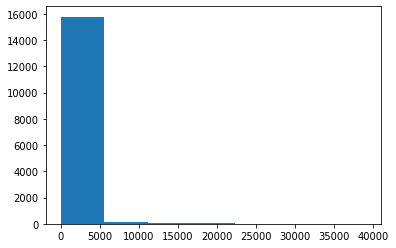

In [56]:
%matplotlib inline
import matplotlib.pyplot as plt

# Reconstruction error binned and plotted.
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(error_df.reconstruction_error.values, bins=7)

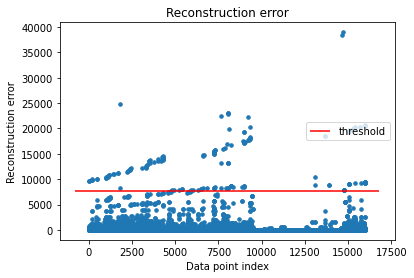

10.130.2.1 200 GET  /profile.php?user=bala HTTP/1.1 
----------------------------------
10.131.2.1 200 GET  /edit.php?name=bala HTTP/1.1 
----------------------------------
10.131.2.1 200 GET  /contestproblem.php?name=Toph%20Contest%202 HTTP/1.1 
----------------------------------
10.131.2.1 200 GET  /details.php?id=3 HTTP/1.1 
----------------------------------
10.131.2.1 200 GET  /contestsubmission.php?id=4 HTTP/1.1 
----------------------------------
10.131.2.1 200 GET  /edit.php?name=ksrsingh HTTP/1.1 
----------------------------------
10.131.0.1 200 GET  /showcode.php?id=285&nm=ksrsingh HTTP/1.1 
----------------------------------
10.131.0.1 200 GET  /profile.php?user=moshiur_cse15 HTTP/1.1 
----------------------------------
10.131.0.1 200 GET  /allsubmission.php?name=moshiur_cse15 HTTP/1.1 
----------------------------------
10.131.2.1 200 GET  /profile.php?user=DevSkill HTTP/1.1 
----------------------------------
10.131.0.1 200 GET  /showcode.php?id=286&nm=Rakib_1603065 HTTP/

In [57]:
threshold = threshold

# Plot reconstruction error vs. the data.
fig, ax = plt.subplots()
ax.plot(error_df.index, error_df.reconstruction_error, marker='o', ms=3.5, linestyle='')
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='threshold')
ax.legend(loc=5)
plt.title("Reconstruction error")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

# Output anomalies.
index_list = []
for index, row in error_df.iterrows():
    if row.reconstruction_error > int(threshold):
        index_list.append(index)

output = []    
for x in index_list:
    output.append(new_x[x])
  

word_ = {value_:key_ for key_,value_ in word_index.items()}
for x in output:
  for x_ in x:
    print(word_[x_],end=' ')
  print('\n----------------------------------')


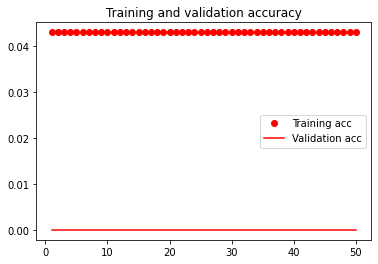

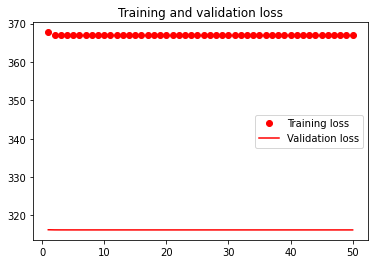

In [62]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1 , len(acc) + 1)

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

* 참조 링크 : https://github.com/zpettry/AI-Autoencoder-for-HTTP-Log-Anomaly-Detection
* 데이터 링크 : https://www.kaggle.com/shawon10/web-log-dataset#webLog.csv